In [1]:
import numpy as np
import pandas as pd
import scipy.linalg

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *


3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]


In [2]:
#import ing dataset
# grand salon
full_dataset = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/grand_salon_20_01_b/slip_dataset_all.pkl')
full_dataset_length = len(full_dataset)
dataset_snow = full_dataset[:int(full_dataset_length/2)]
dataset_test = full_dataset[int(full_dataset_length/2):]

# grand axe
# dataset_snow = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_a/slip_dataset_all.pkl')
# dataset_test = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_b/slip_dataset_all.pkl')
# '/home/dominic/repos/norlab_WMRD/data/marmotte/grand_salon_20_01_b/slip_dataset_all.pkl' # grand salon
# '/home/dominic/repos/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_a/slip_dataset_all.pkl' # snow
# print(dataset_snow)
print(dataset_test)

     init_icp_x  init_icp_y  init_icp_z  init_icp_roll  init_icp_pitch  \
316         0.0         0.0         0.0            0.0             0.0   
317         0.0         0.0         0.0            0.0             0.0   
318         0.0         0.0         0.0            0.0             0.0   
319         0.0         0.0         0.0            0.0             0.0   
320         0.0         0.0         0.0            0.0             0.0   
..          ...         ...         ...            ...             ...   
628         0.0         0.0         0.0            0.0             0.0   
629         0.0         0.0         0.0            0.0             0.0   
630         0.0         0.0         0.0            0.0             0.0   
631         0.0         0.0         0.0            0.0             0.0   
632         0.0         0.0         0.0            0.0             0.0   

     init_icp_yaw  calib_step  cmd_left_0  cmd_right_0  cmd_left_1  ...  \
316           0.0       105.0   -6.8

In [3]:
# extract body_vel_distruptions arrays (output arrays)

str_body_vel_disturption_x_list = []
str_body_vel_disturption_y_list = []
str_body_vel_disturption_yaw_list = []
for i in range(0, 40):
    str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
    str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
    str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
    str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
    str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
    str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)
    
body_vel_disturption_x_array = dataset_snow[str_body_vel_disturption_x_list].to_numpy()
body_vel_disturption_y_array = dataset_snow[str_body_vel_disturption_y_list].to_numpy()
body_vel_disturption_yaw_array = dataset_snow[str_body_vel_disturption_yaw_list].to_numpy()

y_train_longitudinal_slip = body_vel_disturption_x_array.flatten()
y_train_lateral_slip = body_vel_disturption_y_array.flatten()
y_train_angular_slip = body_vel_disturption_yaw_array.flatten()

print(np.max(y_train_angular_slip))

13.505629092308329


In [4]:
# extract interpolated_icp

str_icp_interpolated_x_list = []
str_icp_interpolated_y_list = []
str_icp_interpolated_yaw_list = []
for i in range(0, 40):
    str_icp_interpolated_x_i = 'icp_interpolated_x_' + str(i)
    str_icp_interpolated_y_i = 'icp_interpolated_y_' + str(i)
    str_icp_interpolated_yaw_i = 'icp_interpolated_yaw_' + str(i)
    str_icp_interpolated_x_list.append(str_icp_interpolated_x_i)
    str_icp_interpolated_y_list.append(str_icp_interpolated_y_i)
    str_icp_interpolated_yaw_list.append(str_icp_interpolated_yaw_i)
    
icp_interpolated_x_array = dataset_snow[str_icp_interpolated_x_list].to_numpy()
icp_interpolated_y_array = dataset_snow[str_icp_interpolated_y_list].to_numpy()
icp_interpolated_yaw_array = dataset_snow[str_icp_interpolated_yaw_list].to_numpy()

In [5]:
# extract icp vels

str_icp_vel_x_list = []
str_icp_vel_y_list = []
str_icp_vel_yaw_list = []
for i in range(0, 40):
    str_icp_vel_x_i = 'icp_vel_x_' + str(i)
    str_icp_vel_y_i = 'icp_vel_y_' + str(i)
    str_icp_vel_yaw_i = 'icp_vel_yaw_' + str(i)
    str_icp_vel_x_list.append(str_icp_vel_x_i)
    str_icp_vel_y_list.append(str_icp_vel_y_i)
    str_icp_vel_yaw_list.append(str_icp_vel_yaw_i)
    
icp_vel_x_array = dataset_snow[str_icp_vel_x_list].to_numpy()
icp_vel_y_array = dataset_snow[str_icp_vel_y_list].to_numpy()
icp_vel_yaw_array = dataset_snow[str_icp_vel_yaw_list].to_numpy()

In [6]:
# extract cmd_body_vel arrays (input arrays)

idd_body_vel_x_str_list = []
idd_body_vel_y_str_list = []
idd_body_vel_yaw_str_list = []
for i in range(0, 40):
    str_idd_vel_x_i = 'idd_vel_x_' + str(i)
    str_idd_vel_y_i = 'idd_vel_y_' + str(i)
    str_idd_vel_yaw_i = 'idd_vel_yaw_' + str(i)
    idd_body_vel_x_str_list.append(str_idd_vel_x_i)
    idd_body_vel_y_str_list.append(str_idd_vel_y_i)
    idd_body_vel_yaw_str_list.append(str_idd_vel_yaw_i)
idd_body_vel_x_array = dataset_snow[idd_body_vel_x_str_list].to_numpy()
idd_body_vel_y_array = dataset_snow[idd_body_vel_y_str_list].to_numpy()
idd_body_vel_yaw_array = dataset_snow[idd_body_vel_yaw_str_list].to_numpy()

x_train = np.column_stack((idd_body_vel_x_array.flatten(), idd_body_vel_yaw_array.flatten()))

(-1.5, 1.5)

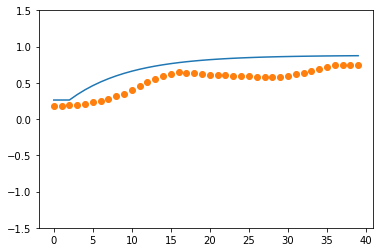

In [7]:
test_window = 180

# x_train = np.zeros((40, 2))
# for i in range(0, 40):
#     x_train[i, 0] = idd_body_vel_x_array[test_window, i]
#     x_train[i, 1] = idd_body_vel_yaw_array[test_window, i]
  
# y_train_longitudinal_slip = body_vel_disturption_x_array[test_window, :]
# y_train_lateral_slip = body_vel_disturption_y_array[test_window, :]
# y_train_angular_slip = body_vel_disturption_yaw_array[test_window, :]

# plt.plot(body_vel_disturption_x_array[test_window, :], 'o')
plt.plot(idd_body_vel_x_array[test_window, :])
plt.plot(icp_vel_x_array[test_window, :], 'o')
# plt.plot(x_train[:, 0])
# plt.plot(icp_interpolated_x_array[test_window, :], 'o', alpha = 0.5)

plt.ylim(-1.5, 1.5)

# print(x_train)


(-4.0, 4.0)

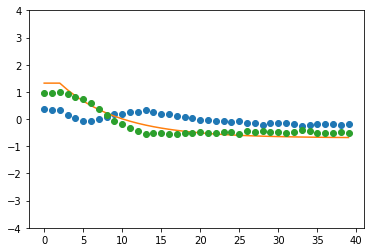

In [8]:
plt.plot(body_vel_disturption_yaw_array[test_window, :], 'o')
plt.plot(idd_body_vel_yaw_array[test_window, :])
# plt.plot(y_train_longitudinal_slip)
plt.plot(icp_vel_yaw_array[test_window, :], 'o')
# plt.plot(icp_interpolated_yaw_array[test_window, :], 'o')

plt.ylim(-4, 4)


In [9]:
# compute mean body vel disturbance for each steady-state window
n_windows = len(dataset_snow)


steady_state_mask = dataset_snow['steady_state_mask'].to_numpy() == True

steady_state_idd_body_vel_x = idd_body_vel_x_array[steady_state_mask]
steady_state_idd_body_vel_y = idd_body_vel_y_array[steady_state_mask]
steady_state_idd_body_vel_yaw = idd_body_vel_yaw_array[steady_state_mask]

steady_state_icp_body_vel_x = icp_vel_x_array[steady_state_mask]
steady_state_icp_body_vel_y = icp_vel_y_array[steady_state_mask]
steady_state_icp_body_vel_yaw = icp_vel_yaw_array[steady_state_mask]

steady_state_body_vel_disturption_x = body_vel_disturption_x_array[steady_state_mask]
steady_state_body_vel_disturption_y = body_vel_disturption_y_array[steady_state_mask]
steady_state_body_vel_disturption_yaw = body_vel_disturption_yaw_array[steady_state_mask]




In [10]:
# compute mean body vel disturptions

mean_body_vel_disturption_x = np.mean(steady_state_body_vel_disturption_x, axis=1)
mean_body_vel_disturption_y = np.mean(steady_state_body_vel_disturption_y, axis=1)
mean_body_vel_disturption_yaw = np.mean(steady_state_body_vel_disturption_yaw, axis=1)

std_dev_body_vel_disturption_x = np.std(steady_state_body_vel_disturption_x, axis=1)
std_dev_body_vel_disturption_y = np.std(steady_state_body_vel_disturption_y, axis=1)
std_dev_body_vel_disturption_yaw = np.std(steady_state_body_vel_disturption_yaw, axis=1)

print(mean_body_vel_disturption_x.shape)

(210,)


In [11]:
# use mean values for each window as observations

x_train = np.column_stack((steady_state_idd_body_vel_x[:, -1], steady_state_idd_body_vel_yaw[:, -1]))

y_train_x = mean_body_vel_disturption_x
y_train_y = mean_body_vel_disturption_y
y_train_yaw = mean_body_vel_disturption_yaw

print(x_train.shape)
print(y_train_yaw.shape)

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.plot_wireframe(x_train[:, 0], x_train[:, 1], np.column_stack((y_train, y_train)), rstride=10, cstride=10)
# plt.show()

(210, 2)
(210,)


In [12]:
# Create gaussian process
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel_x = 1.0 * RBF(length_scale=[0.1, 0.1]) + WhiteKernel(noise_level=0.1)
kernel_y = 1.0 * RBF(length_scale=[0.1, 0.1]) + WhiteKernel(noise_level=0.1)
kernel_yaw = 1.0 * RBF(length_scale=[100, 100]) + WhiteKernel(noise_level=0.5)

print('gpr_x')
gpr_x = GaussianProcessRegressor(kernel=kernel_x, n_restarts_optimizer=20, alpha = std_dev_body_vel_disturption_x**2).fit(x_train, y_train_x)
print('gpr_y')
gpr_y = GaussianProcessRegressor(kernel=kernel_y, n_restarts_optimizer=20, alpha = std_dev_body_vel_disturption_y**2).fit(x_train, y_train_y)
print('gpr_yaw')
gpr_yaw = GaussianProcessRegressor(kernel=kernel_yaw, n_restarts_optimizer=20, alpha = std_dev_body_vel_disturption_yaw**2).fit(x_train, y_train_yaw)



/home/dominic/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dominic/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [13]:
## print train fit score for each dimension

print('gpr_x')
print(gpr_x.score(x_train, y_train_x))
print(gpr_x.kernel_)

print('gpr_y')
print(gpr_y.score(x_train, y_train_y))
print(gpr_y.kernel_)

print('gpr_yaw')
print(gpr_yaw.score(x_train, y_train_yaw))
print(gpr_yaw.kernel_)

gpr_x
0.9949079245513957
0.636**2 * RBF(length_scale=[1.38, 12.7]) + WhiteKernel(noise_level=4.35e-05)
gpr_y
0.9586633225303612
0.186**2 * RBF(length_scale=[3.94, 7.58]) + WhiteKernel(noise_level=1e-05)
gpr_yaw
0.9976611966208463
2.09**2 * RBF(length_scale=[2.73, 6.98]) + WhiteKernel(noise_level=1e-05)


In [14]:
test_body_vel_disturption_x_array = dataset_test[str_body_vel_disturption_x_list].to_numpy()
test_body_vel_disturption_y_array = dataset_test[str_body_vel_disturption_y_list].to_numpy()
test_body_vel_disturption_yaw_array = dataset_test[str_body_vel_disturption_yaw_list].to_numpy()

test_idd_body_vel_x_array = dataset_test[idd_body_vel_x_str_list].to_numpy()
test_idd_body_vel_y_array = dataset_test[idd_body_vel_y_str_list].to_numpy()
test_idd_body_vel_yaw_array = dataset_test[idd_body_vel_yaw_str_list].to_numpy()

test_steady_state_mask = dataset_test['steady_state_mask'].to_numpy() == True

test_steady_state_idd_body_vel_x = test_idd_body_vel_x_array[test_steady_state_mask]
test_steady_state_idd_body_vel_y = test_idd_body_vel_y_array[test_steady_state_mask]
test_steady_state_idd_body_vel_yaw = test_idd_body_vel_yaw_array[test_steady_state_mask]

test_steady_state_body_vel_disturption_x = test_body_vel_disturption_x_array[test_steady_state_mask]
test_steady_state_body_vel_disturption_y = test_body_vel_disturption_y_array[test_steady_state_mask]
test_steady_state_body_vel_disturption_yaw = test_body_vel_disturption_yaw_array[test_steady_state_mask]

In [15]:
test_mean_body_vel_disturption_x = np.mean(test_steady_state_body_vel_disturption_x, axis=1)
test_mean_body_vel_disturption_y = np.mean(test_steady_state_body_vel_disturption_y, axis=1)
test_mean_body_vel_disturption_yaw = np.mean(test_steady_state_body_vel_disturption_yaw, axis=1)

print(test_mean_body_vel_disturption_x.shape)


x_test = np.column_stack((test_steady_state_idd_body_vel_x[:, -1], test_steady_state_idd_body_vel_yaw[:, -1]))

y_test_x = test_mean_body_vel_disturption_x
y_test_y = test_mean_body_vel_disturption_y
y_test_yaw = test_mean_body_vel_disturption_yaw

(212,)


In [16]:
## print test fit score for each dimension

print('gpr_x')
print(gpr_x.score(x_test, y_test_x))
# print(gpr_x.kernel_)

print('gpr_y')
print(gpr_y.score(x_test, y_test_y))
# print(gpr_y.kernel_)

print('gpr_yaw')
print(gpr_yaw.score(x_test, y_test_yaw))
# print(gpr_yaw.kernel_)

gpr_x
0.9505144727239274
gpr_y
0.9198741388392259
gpr_yaw
0.9900413580910419


(-1.0, 1.0)

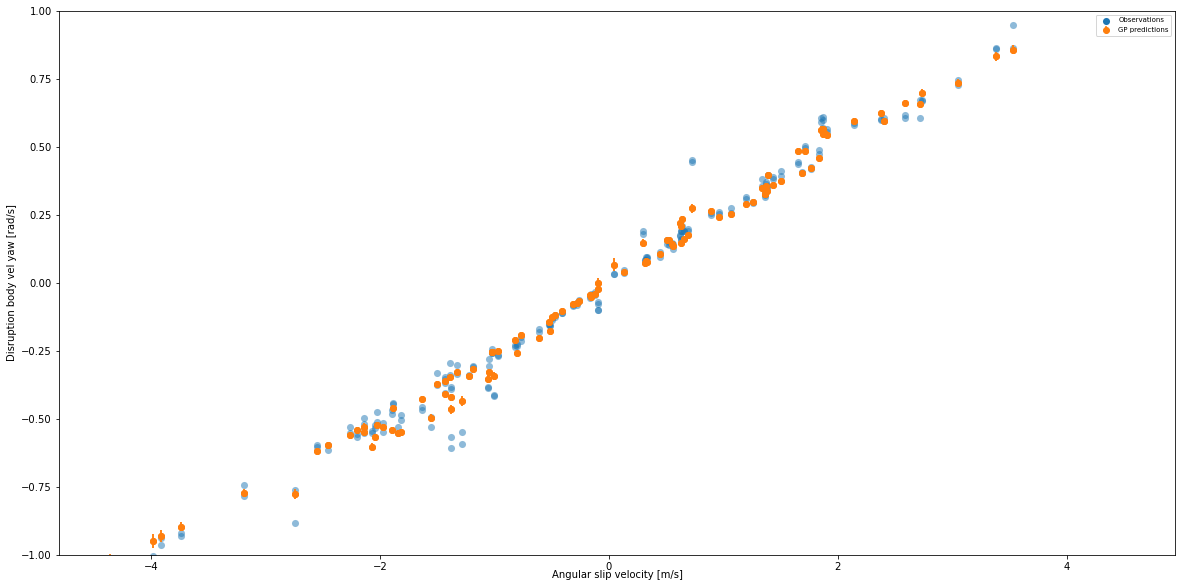

In [17]:
# check yaw gaussian process fit on test data

plt.figure(figsize=(20,10))
ax = plt.gca()
fig = plt.gcf()

line_width = 5
alpha = 0.2


alpha_plot = 0.5

time_vec = np.linspace(0, test_mean_body_vel_disturption_yaw.shape[0], test_mean_body_vel_disturption_yaw.shape[0])

test_ang_slip = ax.scatter(test_steady_state_idd_body_vel_yaw[:, -1], test_mean_body_vel_disturption_yaw, 
                  c = 'C0',
                  cmap = 'viridis', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Observations',
                 rasterized=True)

gpr_yaw_prediction, gpr_yaw_std = gpr_yaw.predict(x_test, return_std=True)
# print(test_steady_state_idd_body_vel_yaw[:, -1].shape)
# print(gpr_yaw_std)
# print(gpr_yaw_prediction.shape)

plt.errorbar(x_test[:, 1], gpr_yaw_prediction, gpr_yaw_std, c='C1', fmt='o', label='GP predictions')

ax.set_xlabel('Angular slip velocity [m/s]', labelpad=-2)
ax.set_ylabel('Disruption body vel yaw [rad/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# ax.set_xlim(-3, 3)

ax.set_ylim(-1, 1)

(-1.0, 1.0)

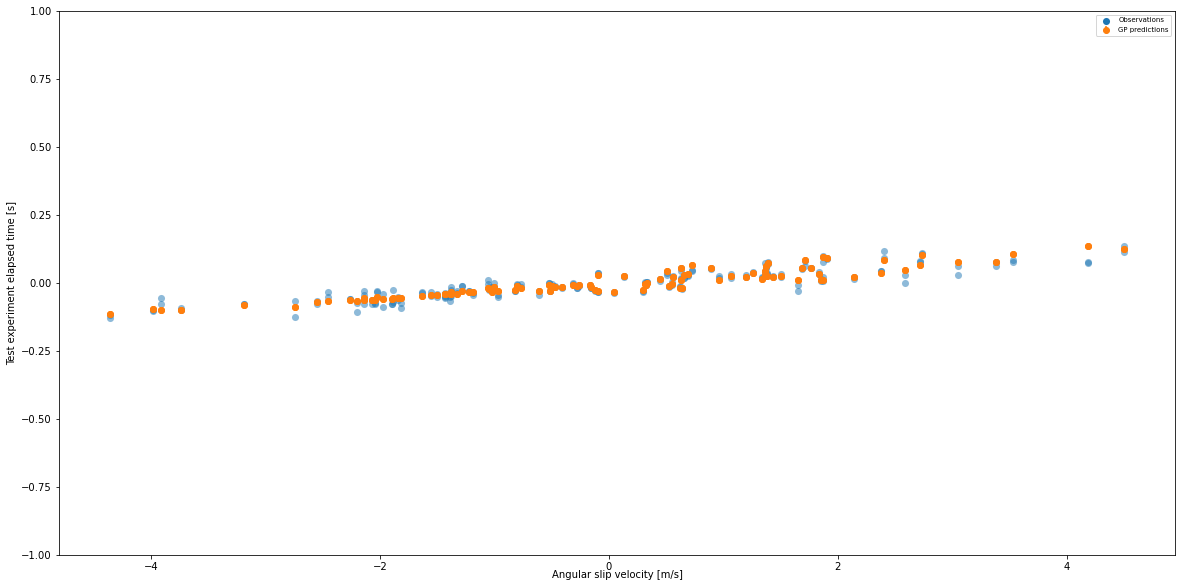

In [18]:
# check y gaussian process fit on test data

plt.figure(figsize=(20,10))
ax = plt.gca()
fig = plt.gcf()

line_width = 5
alpha = 0.2


alpha_plot = 0.5

time_vec = np.linspace(0, test_mean_body_vel_disturption_y.shape[0], test_steady_state_body_vel_disturption_y.shape[0])

test_ang_slip = ax.scatter(test_steady_state_idd_body_vel_yaw[:, -1], test_mean_body_vel_disturption_y, 
                  c = 'C0',
                  cmap = 'viridis', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Observations',
                 rasterized=True)

gpr_y_prediction, gpr_y_std = gpr_y.predict(x_test, return_std=True)
# print(test_steady_state_idd_body_vel_y[:, -1].shape)
# print(gpr_y_std)
# print(gpr_y_prediction.shape)

plt.errorbar(test_steady_state_idd_body_vel_yaw[:, -1], gpr_y_prediction, gpr_y_std, c='C1', fmt='o', label='GP predictions')

ax.set_xlabel('Angular slip velocity [m/s]', labelpad=-2)
ax.set_ylabel('Test experiment elapsed time [s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# ax.set_xlim(-3, 3)

ax.set_ylim(-1, 1)

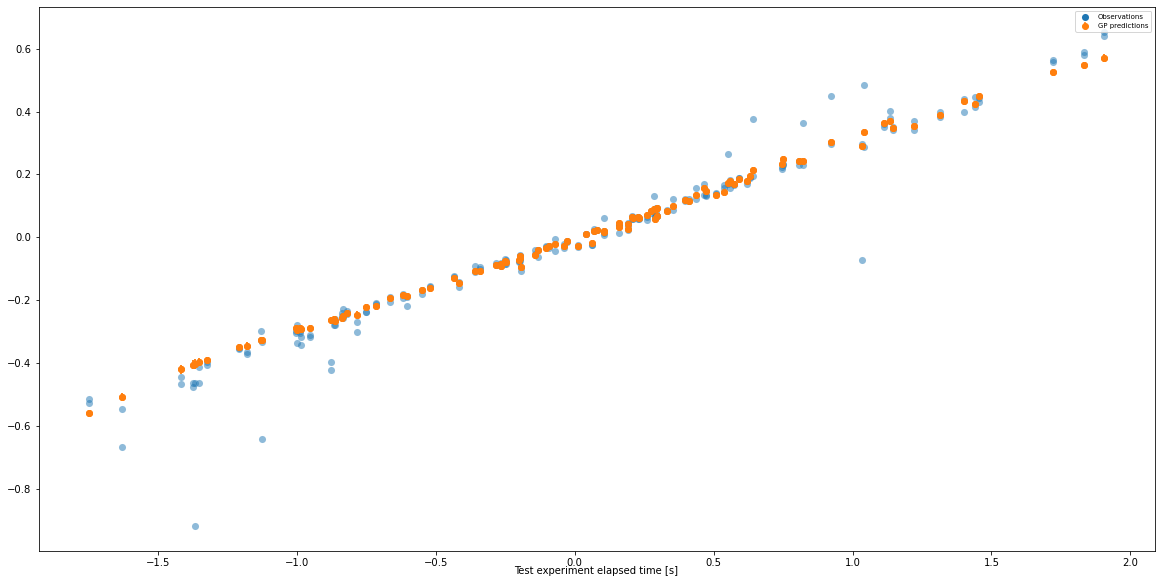

In [19]:
# check y gaussian process fit on test data

plt.figure(figsize=(20,10))
ax = plt.gca()
fig = plt.gcf()

line_width = 5
alpha = 0.2


alpha_plot = 0.5

time_vec = np.linspace(0, test_mean_body_vel_disturption_x.shape[0], test_steady_state_body_vel_disturption_x.shape[0])

test_ang_slip = ax.scatter(test_steady_state_idd_body_vel_x[:, -1], test_mean_body_vel_disturption_x, 
                  c = 'C0',
                  cmap = 'viridis', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Observations',
                 rasterized=True)

gpr_x_prediction, gpr_x_std = gpr_x.predict(x_test, return_std=True)
# print(test_steady_state_idd_body_vel_x[:, -1].shape)
# print(gpr_x_std)
# print(gpr_x_prediction.shape)

plt.errorbar(test_steady_state_idd_body_vel_x[:, -1], gpr_x_prediction, gpr_x_std, c='C1', fmt='o', label='GP predictions')

ax.set_xlabel('Angular slip velocity [m/s]', labelpad=-2)
ax.set_xlabel('Test experiment elapsed time [s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# ax.set_xlim(-3, 3)

# ax.set_xlim(-1, 1)